In [ ]:
!pip install -q -U transformers
!pip install -q -U accelerate
!pip install -q -U bitsandbytes
!pip install pandas matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.1 MB/s eta 0:00:00


In [14]:
import os
path_to_dataset = ""
#Per comodità, per capire se stiamo eseguendo su Google Colab o su Kaggle
if os.path.exists('/content/'):
        path_to_dataset = "/content/train_v2_drcat_02.csv"

    # Verifica se è presente la cartella "input" caratteristica di Kaggle
if os.path.exists('/kaggle/input/'):
        path_to_dataset = "/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv"


In [15]:
import pandas as pd
df = pd.read_csv(path_to_dataset)
#df['text'] = df['text'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44868 entries, 0 to 44867
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           44868 non-null  object
 1   label          44868 non-null  int64 
 2   prompt_name    44868 non-null  object
 3   source         44868 non-null  object
 4   RDizzl3_seven  44868 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 1.4+ MB


### Creazione di train e test

In [16]:
df = df.drop('source',axis = 1)
df = df.drop('RDizzl3_seven',axis = 1)
data = df
data = data.drop('label',axis = 1)
data = data.drop('prompt_name',axis = 1)

In [17]:
data

,text
0,Phones\n\nModern humans today are always on th...
1,This essay will explain if drivers should or s...
2,Driving while the use of cellular devices\n\nT...
3,Phones & Driving\n\nDrivers should not be able...
4,Cell Phone Operation While Driving\n\nThe abil...
...,...
44863,"Dear Senator,\n\nI am writing to you today to ..."
44864,"Dear Senator,\n\nI am writing to you today to ..."
44865,"Dear Senator,\n\nI am writing to you today to ..."
44866,"Dear Senator,\n\nI am writing to you today to ..."


#### Data Cleaning

Togliamo le stop-words.


In [18]:
import tensorflow as tf

import nltk
from nltk.corpus import stopwords
#NLTK
nltk.download('stopwords')
stop = set(stopwords.words('english'))

def remove_stop_words_nltk(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop]
    return ' '.join(filtered_words)
#Alternativa con SpaCy
import spacy
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
print(sw_spacy)

def remove_stop_words_spacy(text):
    words = [word for word in text.split() if word.lower() not in sw_spacy]
    new_text = " ".join(words)
    return new_text

#Alternativa con Gensim
import gensim
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
print(STOPWORDS)

def remove_stop_words_gensim(text):
  new_text = remove_stopwords(text)
  return new_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


{'nobody', 'behind', 'wherein', 'used', 'me', 'had', 'well', 'n‘t', "'m", 'whom', 'onto', 'must', 'therefore', '’ve', 'again', 'what', 'hundred', 'except', 'yourselves', 'at', 'mine', 'off', 'otherwise', 'indeed', 'ca', 'beyond', 'sometimes', 'everywhere', 'move', 'yours', 'been', 'itself', '’d', 'very', 'out', 'them', 'former', 'further', 'least', 'bottom', 'myself', 'nevertheless', 'never', 'anyhow', 'among', 'its', 'alone', 'done', 'who', 'one', "'re", 'whatever', 'besides', '’re', 'below', 'him', 'themselves', "'d", 'down', 'throughout', 'thereupon', 'of', 'though', 'where', 'whoever', 'first', 'sixty', 'made', 'our', 'few', 'last', 'three', 'formerly', 'will', 'noone', 'is', 'latter', 'when', 'via', 'neither', 'might', 'please', 'regarding', 'against', 'often', 'once', 'hereupon', 'make', 'six', 'into', 'herself', 'how', 'some', 'by', 'twelve', 'there', 'doing', 'above', 'whereafter', 'and', 'their', 'all', 'you', '‘m', 're', "'ve", '‘d', 'an', 'these', 'although', 'from', 'they',

In [19]:
for index,row in data.iterrows():
  #print(f"{index} {row}")
  new_string = remove_stop_words_spacy(row['text'])
  data.at[index,'text'] = new_string


data.head(1)
#data_without_stopwords = [remove_stop_words_spacy(text) for text in data['text']]

,text
0,Phones Modern humans today phone. phone 5 hour...


Togliamo la punteggiatura e i caratteri speciali

In [20]:
import string


def remove_punctuation_with_string(text):
    new_text = ""
    for word in text:
      for i in range(len(word)):
        if word[i] not in string.punctuation:
          new_text+=word[i]
    return new_text

for index,row in data.iterrows():
  #print(f"{index} {row}")
  new_string = remove_punctuation_with_string(row['text'])
  data.at[index,'text'] = new_string


data.head(1)




,text
0,Phones Modern humans today phone phone 5 hours...


In [ ]:
lunghezza_massima = max(len(sequenza.split()) for sequenza in data['text'])

print("Lunghezza massima delle sequenze:", lunghezza_massima)

Lunghezza massima delle sequenze: 1656


In [ ]:
import math
# Calcola la lunghezza media delle sequenze nel dataset
lunghezza_medio = sum(len(sequenza.split()) for sequenza in data['text']) / len(data['text'])
lunghezza_medio = math.ceil(lunghezza_medio)
print("Lunghezza media delle sequenze:", lunghezza_medio)

Lunghezza media delle sequenze: 384


In [ ]:
import numpy as np
# Calcola la lunghezza delle sequenze
lunghezze_sequenze = [len(sequenza.split()) for sequenza in data['text']]

# Scegli il percentile desiderato (ad esempio, il 95° percentile)
percentile_desiderato = 95

# Calcola il valore del percentile
lunghezza_percentile = np.percentile(lunghezze_sequenze, percentile_desiderato)

lunghezza_percentile =  math.ceil(lunghezza_percentile)

print(f"{percentile_desiderato}° percentile della lunghezza delle sequenze:", lunghezza_percentile)

95° percentile della lunghezza delle sequenze: 713


In [ ]:
from sklearn.model_selection import train_test_split

# Supponiamo che il tuo dataset sia rappresentato da X (feature) e y (etichette)
X_train, X_temp, y_train, y_temp = train_test_split(data['text'], df['label'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Create text encoder


In [ ]:
VOCAB_SIZE = 1000 #Parametro da sistemare
#X_train_no_stopwords = [remove_stop_words(text) for text in X_train.values.flatten()]
#X_train_no_stopwords_spacy = [remove_stop_words_spacy(text) for text in X_train.values.flatten()]
#X_train_no_stopwords_gensim = [remove_stop_words_gensim(text) for text in X_train.values.flatten()]
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE) #output_sequence_length=50 in alternativa ad input_length
encoder.adapt(X_train.values.flatten())

In [ ]:
#X_train.head() non serve perchè lo fa la rete

In [ ]:
#X_train = encoder(X_train) non serve perchè lo fa la rete

In [ ]:
#X_train non serve perchè lo fa la rete

##### Controlliamo se l'encoder funziona

In [ ]:
import numpy as np
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'students', 'people', 'school', 'like', 'help',
       'time', 'car', 'cars', 'electoral', 'college', 'think', 'work',
       'student', 'way', 'states', 'good', 'vote', 'better'], dtype='<U15')

### Applichiamo il Padding (VEDERE MEGLIO COME FARE QUESTA COSA)


In [ ]:
#from tensorflow.keras.preprocessing.sequence import pad_sequences
#X_train = pad_sequences(X_train, padding='post', maxlen=100)

In [ ]:
#X_train

### Creiamo un embedding

In [ ]:
embedding_layer = tf.keras.layers.Embedding(1000, 5) #SERVE SOLO DA ESEMPIO IL VERO PADDING è NELLA RETE

In [ ]:
#TEST PER VEDERE SE FUNZIONA IL LAYER EMBEDDING #SERVE SOLO DA ESEMPIO IL VERO PADDING è NELLA RETE
result = embedding_layer(tf.constant([1, 2, 3]))
result.numpy()

array([[-0.02189764,  0.01844749,  0.03760279, -0.03621973, -0.04450296],
       [ 0.04972217,  0.0263911 ,  0.01721891,  0.03477538, -0.00472718],
       [ 0.00657231, -0.02893483,  0.02589095, -0.02704761,  0.01037016]],
      dtype=float32)

## Creazione modello

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        #gestire anche dimensione input e output
        input_dim=len(encoder.get_vocabulary()),
        output_dim=3,
        # aggiungere input_length  =  lunghezza massima o come media o come percentile 95%
        input_length = lunghezza_massima,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
#model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#              optimizer=tf.keras.optimizers.Adam(1e-4), # default 0.01
#              metrics=['accuracy'])
# -> Da un warning strano, quello di sotto no
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

5233     0
28816    1
1550     0
1888     0
16987    0
        ..
11284    0
44732    1
38158    1
860      0
15795    0
Name: label, Length: 35894, dtype: int64

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
561/561 [==============================] - 380s 661ms/step - loss: 0.2057 - accuracy: 0.9119 - val_loss: 0.0505 - val_accuracy: 0.9837
Epoch 2/10
561/561 [==============================] - 371s 661ms/step - loss: 0.0578 - accuracy: 0.9818 - val_loss: 0.0566 - val_accuracy: 0.9831
Epoch 3/10
561/561 [==============================] - 372s 663ms/step - loss: 0.0419 - accuracy: 0.9869 - val_loss: 0.0871 - val_accuracy: 0.9753
Epoch 4/10
561/561 [==============================] - 363s 646ms/step - loss: 0.0323 - accuracy: 0.9900 - val_loss: 0.0881 - val_accuracy: 0.9835
Epoch 5/10
561/561 [==============================] - 373s 666ms/step - loss: 0.0309 - accuracy: 0.9911 - val_loss: 0.0461 - val_accuracy: 0.9846
Epoch 6/10
561/561 [==============================] - 379s 675ms/step - loss: 0.0225 - accuracy: 0.9930 - val_loss: 0.0435 - val_accuracy: 0.9862
Epoch 7/10
561/561 [==============================] - 372s 664ms/step - loss: 0.0275 - accuracy: 0.9919 - val_loss: 0.0862 -

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

141/141 [==============================] - 15s 103ms/step - loss: 0.0535 - accuracy: 0.9835
Test Loss: 0.05354010686278343
Test Accuracy: 0.9835079312324524


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score



y_pred = model.predict(X_test)
y_pred = y_pred.astype(int)
y_test = y_test.astype(int)

# Stampa il classification report e l'accuracy score
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(report)
print("****")
print(accuracy)




141/141 [==============================] - 17s 98ms/step
              precision    recall  f1-score   support

           0       0.61      1.00      0.76      2729
           1       1.00      0.02      0.03      1758

    accuracy                           0.61      4487
   macro avg       0.81      0.51      0.39      4487
weighted avg       0.76      0.61      0.47      4487

****
0.6142188544684645


In [ ]:
print(report)
print("****")
print(accuracy)

              precision    recall  f1-score   support

           0       0.61      1.00      0.76      2729
           1       1.00      0.02      0.03      1758

    accuracy                           0.61      4487
   macro avg       0.81      0.51      0.39      4487
weighted avg       0.76      0.61      0.47      4487

****
0.6142188544684645


In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.21494219629094005)

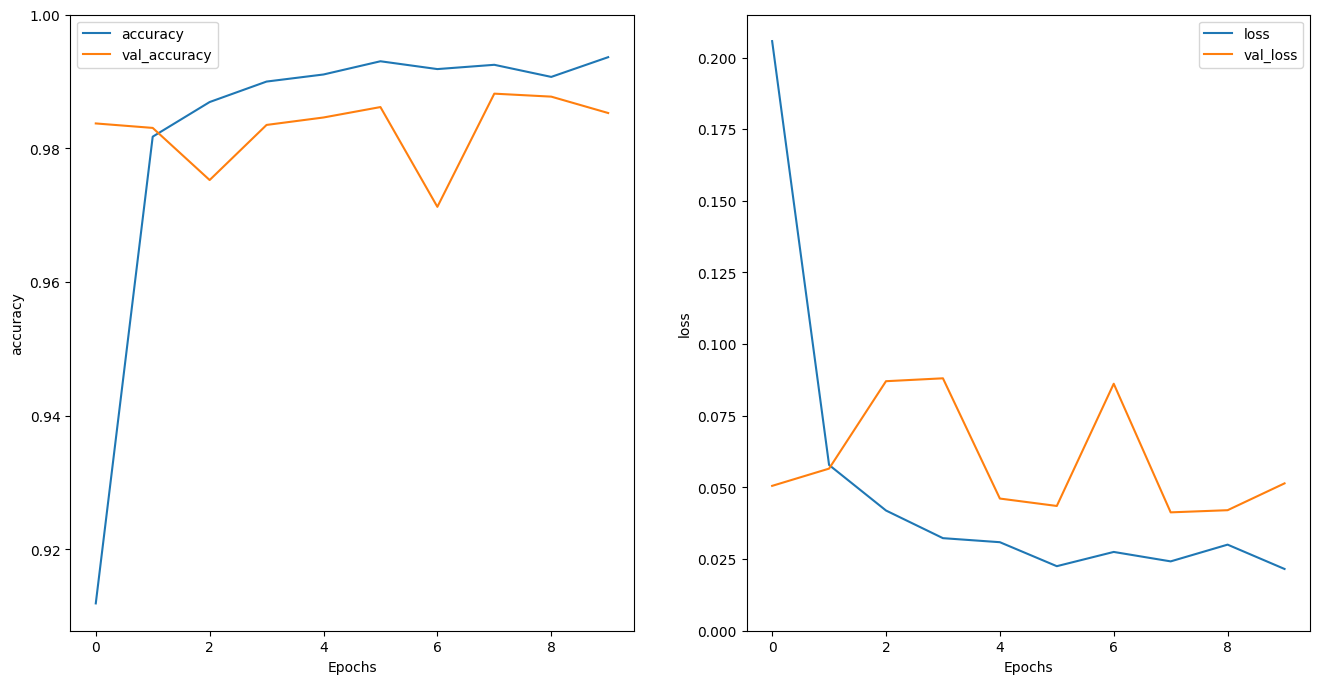

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
for key in X_test :
    predictions = model.predict(np.array([key]))
    print(predictions)
    break

TypeError: ignored

In [ ]:
for key in y_test :
    print(key)
    break